In [148]:
import gzip        
import pickle    
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.signal import find_peaks



In [149]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

In [150]:
def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

# INPUT: TEST VARIABLE + TEST VALUE + FILEPATH

In [151]:
variable = "LinearAmax-0.03"
value = "15k"
path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_08_20__14_11_19.pkl.gz"
with gzip.open(path, 'rb') as f:
    DATA_dict = pickle.load(f)



title_GL_basic = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_basic = "Mesh Index"
yaxis_GL_basic = "Timestep (yrs)"

title_GL_better = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_better = "Time (yrs)"
yaxis_GL_better = "Grounding Line Position (km)"

title_GLandVel = "Velocity Comparison to Grounding Line Location: " + variable + " " + value
xaxis_vel = "Time (yrs)"
yaxis_vel  = "Velocity (m/yr)"

title_SMB = "Glacier Surface: Accumulation/Ablation " +  variable + " " + value
xaxis_SMB = "Maximum Accumulation to Maximum Ablation (m/yr)"
yaxis_SMB = "Ice Surface Elevation (m)"

title_H = "Ice Thickness Behind Terminus: " +  variable + " " + value
xaxis_H = "Time (yrs)"
yaxis_H = ""

title_bed = "Bedrock Erosion Evolution: " + variable + " " + value
xaxis_bed = "Distance (km)"
yaxis_bed = "Bed Elevation (m)"

print(title_GL_basic)

Grounding Line Evolution: LinearAmax-0.03 15k


## OPENING INDIVIDUAL DICTIONARIES

In [152]:
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']
final_time = list(GL_dict)[-1]
print(final_time)


15000.246465334838


## BASIC GL PLOT

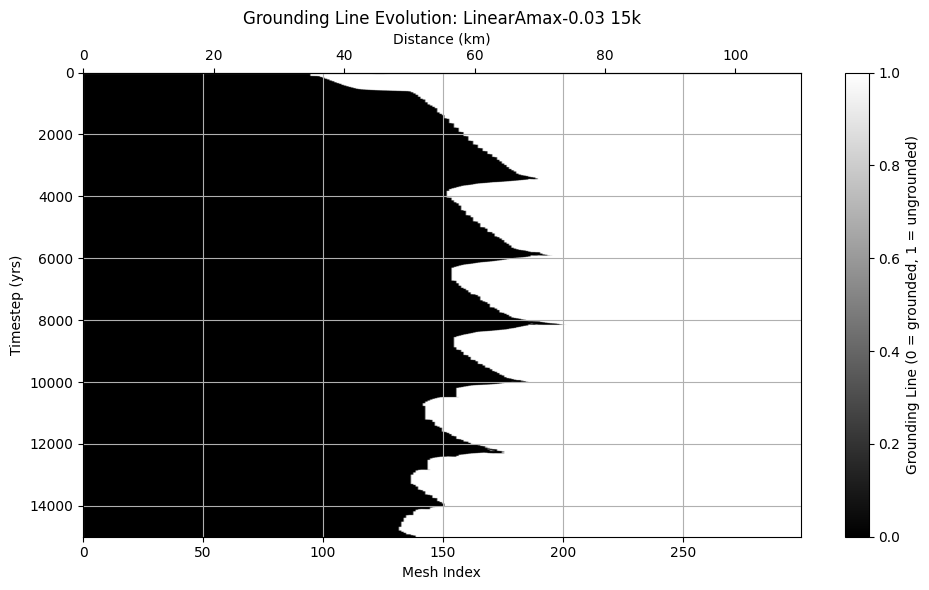

In [153]:
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)
ax.set_ylabel(yaxis_GL_basic)
ax.set_xlabel(xaxis_GL_basic)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(title_GL_basic)
# ax.set_ylim(10000)


# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.grid()
plt.show()

## BETTER GL PLOT

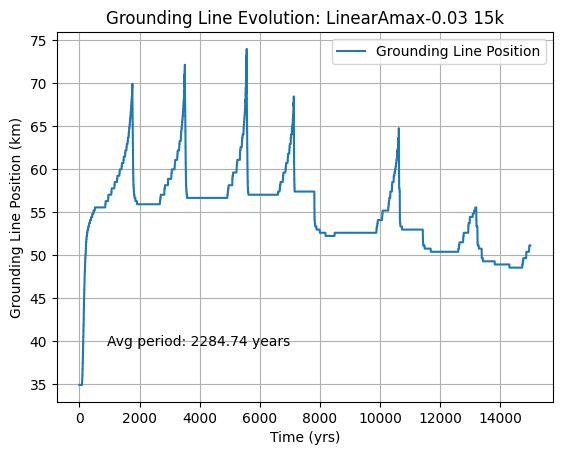

Mean cycle period: 2284.74 years
[1748.61375255 2057.19020998 1566.5983796  3491.84674816 2559.46124435]
Mean advance amplitude: 67.45 km
[69.89966555 72.10702341 73.94648829 68.42809365 64.74916388 55.55183946]
Mean retreat amplitude: 54.45 km
[55.91973244 56.65551839 57.02341137 52.24080268 50.40133779]


In [154]:
fig, ax = plt.subplots()

gl_positions = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions.append(idx)

gl_positions = np.array(gl_positions)
GL_km = mesh_index_to_km(gl_positions)

peaks, _ = find_peaks(GL_km, prominence=5) 
troughs, _ = find_peaks(-GL_km, prominence=5)     
periods = np.diff(np.array(time)[peaks])
adv_dists = GL_km[peaks]
ret_dists = GL_km[troughs]


plt.plot(time, GL_km, label='Grounding Line Position')
# plt.plot(np.array(time)[peaks], GL_km[peaks], 'go', label='Extended State')
# plt.plot(np.array(time)[troughs], GL_km[troughs], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods):.2f} years', transform=plt.gca().transAxes)
plt.legend()
# plt.xlim(0,10000)
plt.xlabel(xaxis_GL_better)
plt.ylabel(yaxis_GL_better)
plt.title(title_GL_better )
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods):.2f} years")
print(periods)

print(f"Mean advance amplitude: {np.mean(adv_dists):.2f} km")
print(adv_dists)

print(f"Mean retreat amplitude: {np.mean(ret_dists):.2f} km")
print(ret_dists)



### Pulling Velocity Data

In [155]:
term_surface_velocity = []
term_basal_velocity = []

for t in sorted(us_dict.keys()): 
    us_ = us_dict[t]
    ub_ = ub_dict[t]

    notNAN = np.where(np.isfinite(us_))[0]

    if len(notNAN) > 0:
        terminus = notNAN[-1]
    else:
        terminus = None

    if terminus is not None and terminus >= 75:
        term_usvel = us_[terminus - 75]
        term_ubvel = ub_[terminus - 75]
    else:
        term_usvel = 0
        term_ubvel = 0

    if np.isnan(term_usvel):
        term_usvel = 0
    if np.isnan(term_ubvel):
        term_ubvel = 0

    term_surface_velocity.append(term_usvel)
    term_basal_velocity.append(term_ubvel)

## VELOCITY OVER GL PLOT

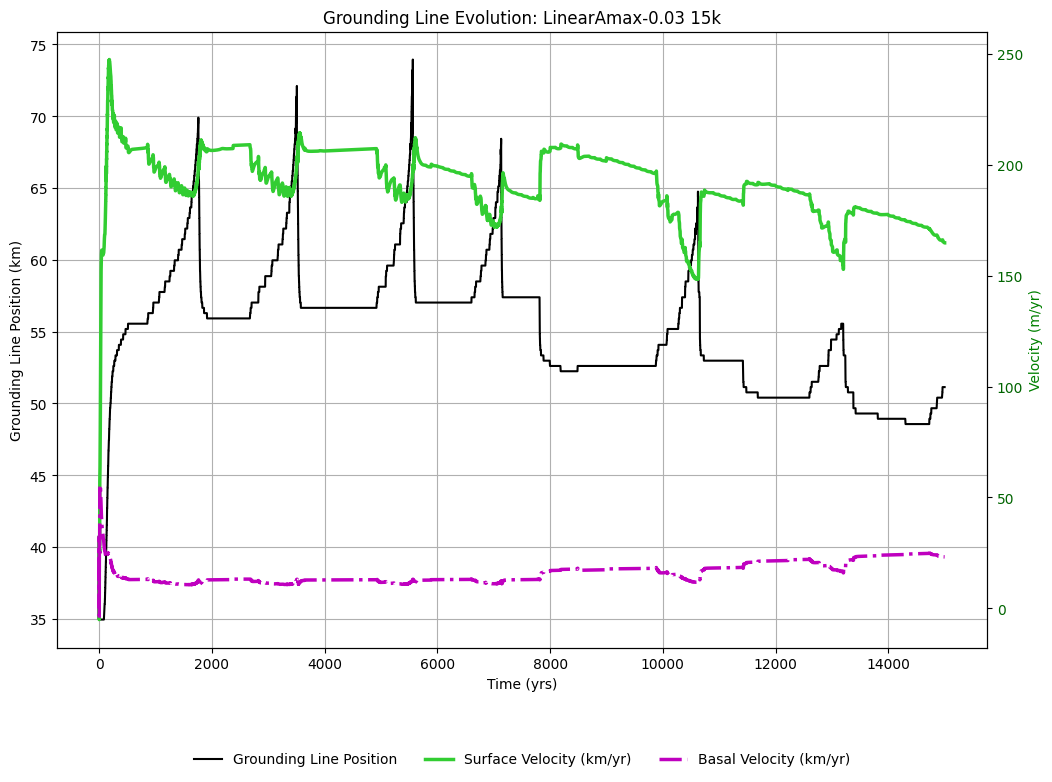

In [156]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Velocity
ax2 = ax1.twinx()
ax2.plot(time, term_surface_velocity, 'limegreen', ls = '-', label='Surface Velocity (km/yr)', linewidth = 2.5)
ax2.plot(time, term_basal_velocity, 'm-.', label='Basal Velocity (km/yr)',  linewidth = 2.5)
ax2.set_ylabel(yaxis_vel, color='green')
ax2.tick_params(axis='y', labelcolor='darkgreen')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.title(title_GL_better )

# plt.title(title_GLandVel)
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/40k_default_all.svg", format ="svg", bbox_inches='tight')



## BED ELEVATION CHANGE PLOT

In [157]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# num_points = len(next(iter(bed_dict.values())))
# x_km = mesh_index_to_km(np.arange(num_points))
# time = list(bed_dict.keys())
# # bed_profile = bed_dict[timesteps[0]] 
# norm = plt.Normalize(min(time), max(time))
# cmap = cm.jet

# fig, ax1 = plt.subplots(figsize=(14,5))

# for i, t in enumerate(time):
#     if i % 1000 != 0:  
#         continue

#     bed = bed_dict[t]
#     color = cmap(norm(t))
#     plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

# plt.xlabel(xaxis_bed)
# plt.ylabel(yaxis_bed)
# # plt.title(title_bed)
# # plt.gca().invert_xaxis() 
# # plt.legend(loc="upper right", fontsize=7)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(25,70)
# plt.ylim(-400,400)
# plt.colorbar()
# # plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

# plt.tight_layout()
# plt.show()
# # fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BedEvo_Ref_plot_40k_default.svg", format ="svg", bbox_inches='tight')


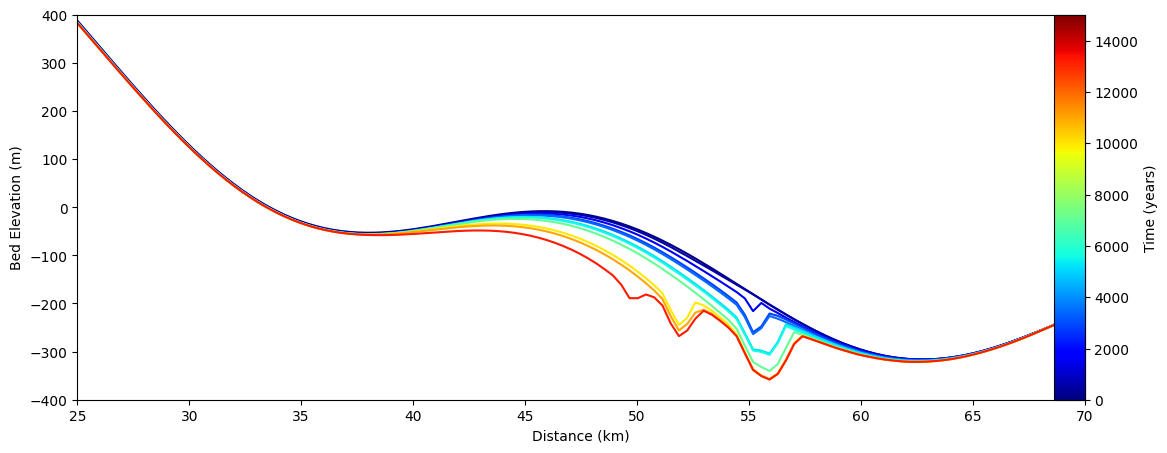

In [158]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(13,5))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue
    bed = bed_dict[t]
    color = cmap(norm(t))
    ax1.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

ax1.set_xlabel(xaxis_bed)
ax1.set_ylabel(yaxis_bed)
ax1.set_xlim(25, 70)
ax1.set_ylim(-400, 400)

# Make ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbaxes = inset_axes(ax1, width="3%", height="100%", loc='upper right',
                    bbox_to_anchor=(0, 0, 1, 1),
                    bbox_transform=ax1.transAxes, borderpad=0.01)

cbar = plt.colorbar(sm, cax=cbaxes)
cbar.set_label('Time (years)')
plt.show()


# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BedEvo_plot_40k_default.svg", format ="svg")



## SMB PLOT

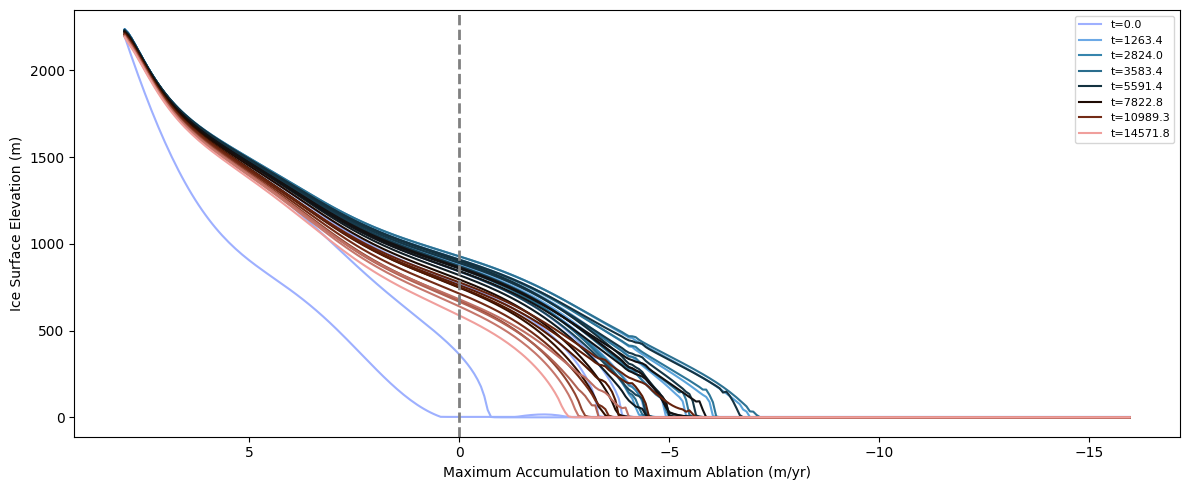

[ 5.174650e+00  5.103950e+00  5.033250e+00  4.962550e+00  4.891850e+00
  4.821150e+00  4.750450e+00  4.679750e+00  4.609050e+00  4.538350e+00
  4.467650e+00  4.396950e+00  4.326250e+00  4.255550e+00  4.184850e+00
  4.114150e+00  4.043450e+00  3.972750e+00  3.902050e+00  3.831350e+00
  3.760650e+00  3.689950e+00  3.619250e+00  3.548550e+00  3.477850e+00
  3.407150e+00  3.336450e+00  3.265750e+00  3.195050e+00  3.124350e+00
  3.053650e+00  2.982950e+00  2.912250e+00  2.841550e+00  2.770850e+00
  2.700150e+00  2.629450e+00  2.558750e+00  2.488050e+00  2.417350e+00
  2.346650e+00  2.275950e+00  2.205250e+00  2.134550e+00  2.063850e+00
  1.993150e+00  1.922450e+00  1.851750e+00  1.781050e+00  1.710350e+00
  1.639650e+00  1.568950e+00  1.498250e+00  1.427550e+00  1.356850e+00
  1.286150e+00  1.215450e+00  1.144750e+00  1.074050e+00  1.003350e+00
  9.326500e-01  8.619500e-01  7.912500e-01  7.205500e-01  6.498500e-01
  5.791500e-01  5.084500e-01  4.377500e-01  3.670500e-01  2.963500e-01
  2.25

In [159]:
timesteps = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timesteps[0]] 
cmap = cm.berlin

fig,ax  = plt.subplots(figsize=(12,5))


counts = sorted(counter_dict.values())  # all loop counts
sample_counts = counts[::300] 

# make a lookup: loop count → time
loop_to_time = {v: k for k, v in counter_dict.items()}

for j, c in enumerate(sample_counts):
    t = loop_to_time[c]
    surf = surf_dict[t]
    color = cmap(norm(t))
    label = f't={t:.1f}' if j % 5 == 0 else ""
    plt.plot(smb_profile, surf, color=color, label=label)


plt.xlabel(xaxis_SMB)
plt.ylabel(yaxis_SMB)
# plt.title(title_SMB)
plt.gca().invert_xaxis()
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SMB_plot_40k_default.svg", format ="svg", bbox_inches='tight')

final_smb = list(SMB_dict.values())[-1]
print(final_smb)

## Plotting Thickness

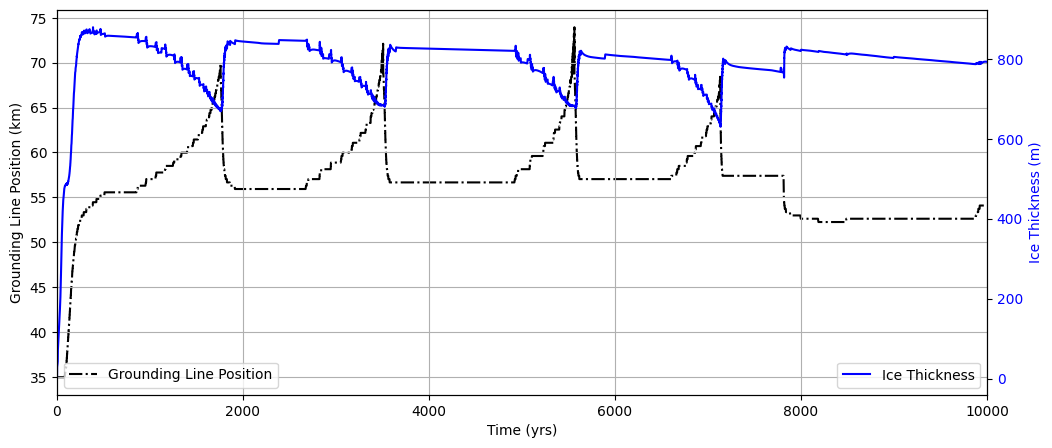

Thickness Max: [1376 2918 3458 4500 5003 6105 6624 7530]
GL Max: [2451 4213 5801 7119]


In [160]:
term_thinning = []
dist_behind_terminus = 50
mask = np.array(time) <= 10000
time_steps = sorted(H_dict.keys())
timesteps = np.array(time)[mask]



for t in time_steps:
    H_ = H_dict[t]

    terminus_indices = np.where(H_ > 1.0)[0]

    if len(terminus_indices) == 0:
        term_thinning.append(np.nan)
        continue

    terminus = terminus_indices[-1]

    if terminus >= dist_behind_terminus:
        term_H = H_[terminus - dist_behind_terminus]
    else:
        term_H = np.nan

    term_thinning.append(term_H)

peaks_gl, _ = find_peaks(GL_km, prominence=6, height=60) 
peaks_gl = np.array(peaks_gl)[mask[peaks_gl]]

peaks_H, _ = find_peaks(term_thinning, prominence=10, height = 600, distance = 500)     
peaks_H = np.array(peaks_H)[mask[peaks_H]]


fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_zorder(2)
ax1.patch.set_visible(False)


ax1.plot(time, GL_km, label='Grounding Line Position', ls = 'dashdot', color='black', zorder=1)
# ax1.plot(np.array(time)[peaks_gl], GL_km[peaks_gl], 'ro', label='Maximum Advance', markersize = 10, zorder=10)
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(0,10000)
ax1.grid()

# Secondary axis for velocities
ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Ice Thickness', zorder=1)
# ax2.plot(np.array(time_steps)[peaks_H], np.array(term_thinning)[peaks_H], 'go', label='Thickness Peaks', markersize = 10, zorder=10)
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.legend(loc = 4)
ax1.legend(loc = 3)

# plt.title(title_H)
plt.show()

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/IceThickness_plot_40k_default.svg", format ="svg", bbox_inches='tight')

print(f"Thickness Max: {peaks_H[1:]}")
print(f"GL Max: {peaks_gl}")
# print(peaks_H[1:] - peaks_gl) 

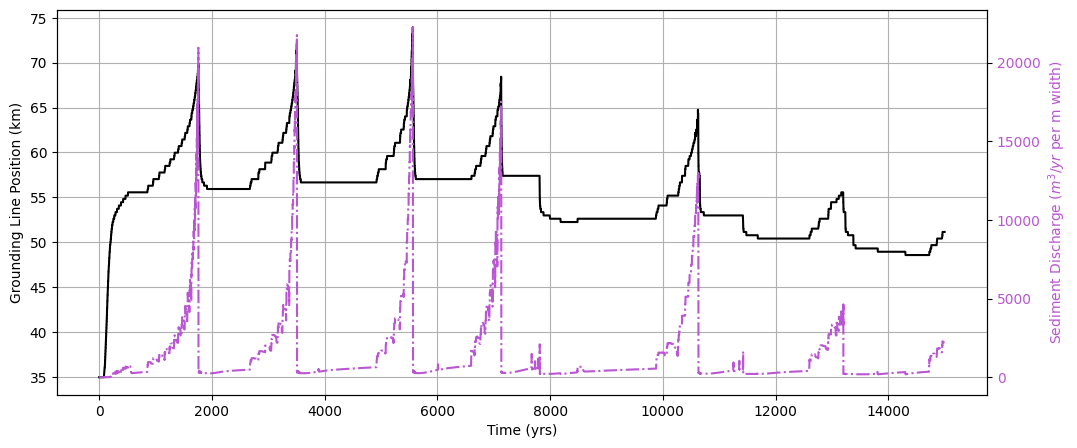

In [161]:

max_Qs = np.array([max(values) for values in Qs_dict.values()])
time = np.array(list(Qs_dict.keys()))
# mask = time <= 10000

# time = time[mask]
# max_Qs = max_Qs[mask]

# MAX_QS = np.max(max_Qs)


fig, ax1 = plt.subplots(figsize=(12, 5))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
# ax1.set_xlim(6000,13500)
ax1.grid()

# Velocity
ax2 = ax1.twinx()
ax2.plot(time, max_Qs, 'mediumorchid', ls = '-.', label='Surface Velocity (km/yr)')
ax2.set_ylabel("Sediment Discharge ($m^3/yr$ per m width)", color='mediumorchid')
ax2.tick_params(axis='y', labelcolor='mediumorchid')

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SedDis_plot_40k_default.svg", format ="svg", bbox_inches='tight')


## Velocity VS Thickness


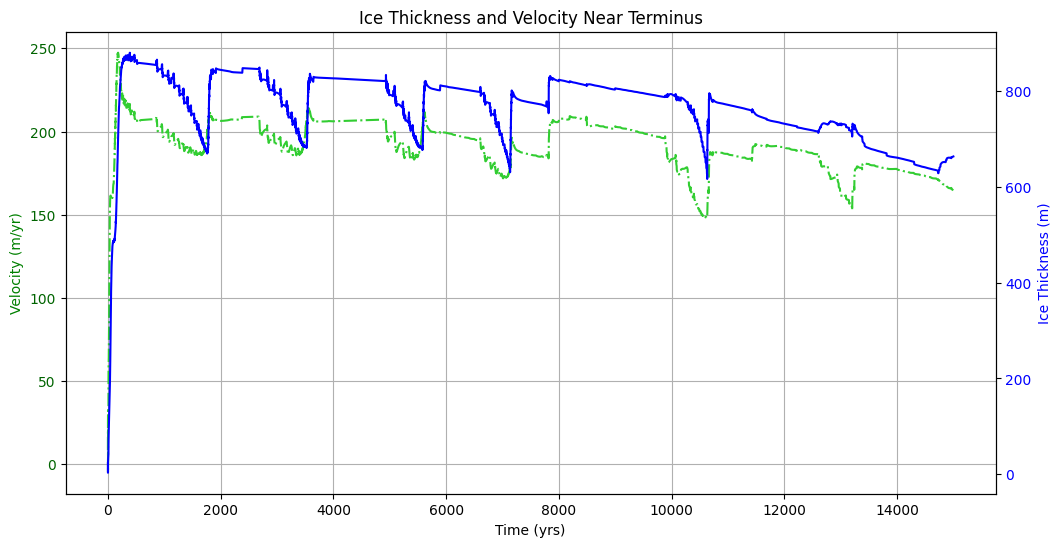

In [162]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time, term_surface_velocity, 'limegreen', ls = '-.', label='Surface Velocity (km/yr)')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_vel, color='green')
ax1.tick_params(axis='y', labelcolor='darkgreen')
# ax1.set_xlim(0,10000)
ax1.grid()


ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Thickness {dist_behind_terminus} nodes behind terminus')
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.title("Ice Thickness and Velocity Near Terminus")
plt.show()


In [163]:
vel_peaks, _ = find_peaks(term_surface_velocity, prominence=5) 
H_peaks, _ = find_peaks(term_thinning, prominence=5)     

Text(0, 0.5, 'Near Terminus Surface Velocity')

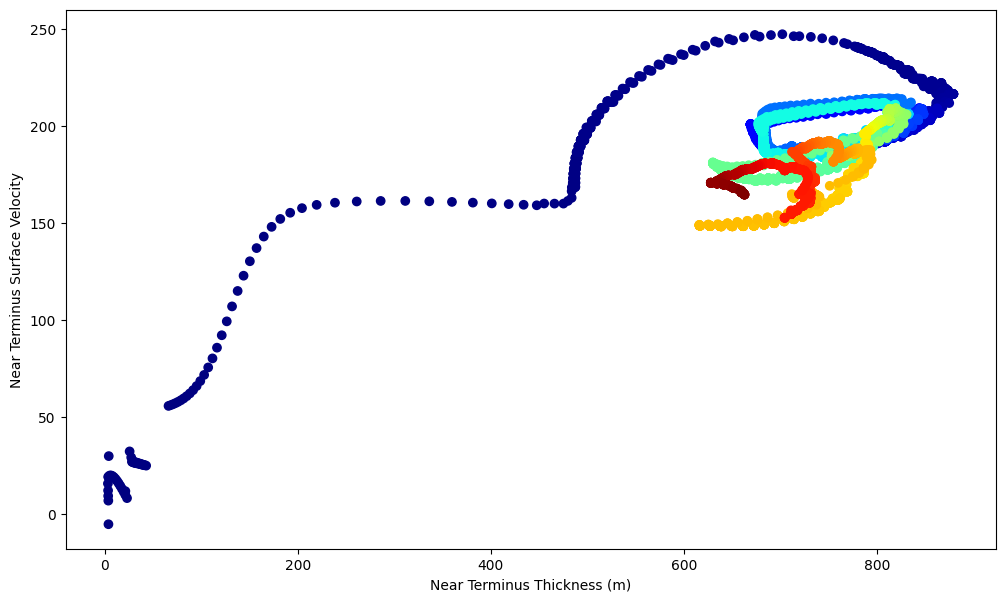

In [164]:
fig,ax = plt.subplots(figsize = (12,7))
plt.scatter(term_thinning, term_surface_velocity, c = time, cmap = 'jet')
plt.xlabel("Near Terminus Thickness (m)")
plt.ylabel("Near Terminus Surface Velocity")

In [ ]:
print(np.size(vel_peaks))
print(np.size(H_peaks))

20
97


: 